In [3]:
import torch
import torch.nn.functional as F
import numpy as np
import PIL.Image as pim
%matplotlib inline
import matplotlib.pyplot as plt

In [219]:
import warnings
warnings.filterwarnings('ignore')

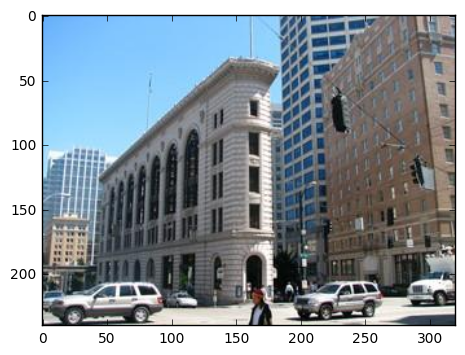

In [79]:
image = plt.imread('images/0010950.jpg')
plt.imshow(image)

In [10]:
image_tensor = torch.Tensor([np.array(image).transpose((2,0,1))])

In [11]:
image_tensor.shape

torch.Size([1, 3, 240, 320])

In [12]:
radius = 3

### Gaussian Kernel  
The weights of this filter sums up to 1. 
So convolving this filter with the original image gives a weighted mean.

In [13]:
def gaussian_filter(kernel_shape):
    x = np.zeros(kernel_shape, dtype='float32')
 
    def gauss(x, y, sigma=2.0):
        Z = 2 * np.pi * sigma ** 2
        return  1. / Z * np.exp(-(x ** 2 + y ** 2) / (2. * sigma ** 2))
 
    mid = np.floor(kernel_shape[-1] / 2.)
    for kernel_idx in range(0, kernel_shape[1]):
        for i in range(0, kernel_shape[2]):
            for j in range(0, kernel_shape[3]):
                x[0, kernel_idx, i, j] = gauss(i - mid, j - mid)
 
    return x / np.sum(x)

In [220]:
gfilter = torch.Tensor(gaussian_filter((1,3,9,9)))

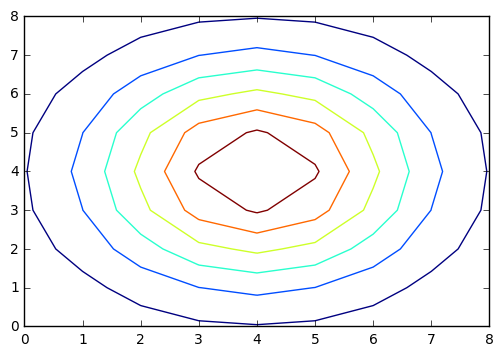

In [221]:
plt.contour(gfilter.numpy()[0][2])

Applying the Convolution

In [18]:
filtered = F.conv2d(image_tensor,gfilter,padding=8) ## padding = 8 = 9-1 (radius - 1 ) for border == 'full'

In [19]:
filtered.byte().numpy()[0][0].shape

(248, 328)

The filtered output

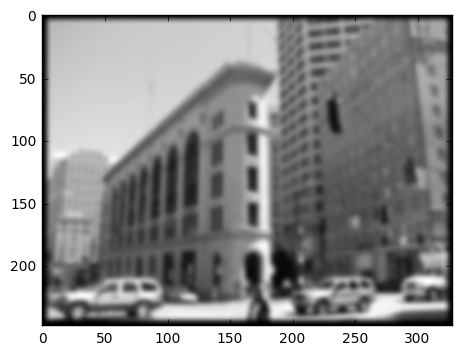

In [33]:
plt.imshow(filtered[0][0],cmap='gray')

Removing the padding boundary added

In [29]:
mid = int(np.floor(gfilter.shape[2] / 2.))

In [30]:
filtered[:,:,mid:-mid,mid:-mid].shape

torch.Size([1, 1, 240, 320])

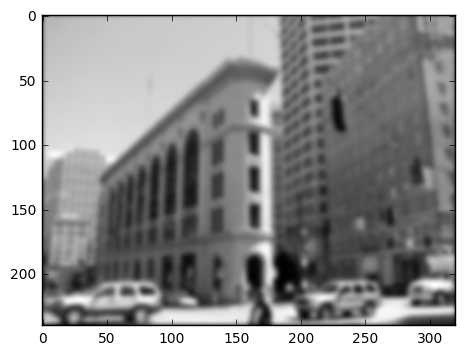

In [32]:
plt.imshow(filtered[:,:,mid:-mid,mid:-mid][0][0],cmap='gray')

### Centered Image
The centered image should have a mean close to 0

In [37]:
centered_image = image_tensor - filtered[:,:,mid:-mid,mid:-mid]

In [38]:
centered_image[0].mean()  ##  mean is close 0 (If we take a finer filter, the mean will tend to 0)

tensor(1.6493)

In [44]:
centered_image.shape

torch.Size([1, 3, 240, 320])

In [81]:
centered_image[0].numpy().shape

(3, 240, 320)

In [121]:
pf = centered_image[0].numpy().transpose((1,2,0))

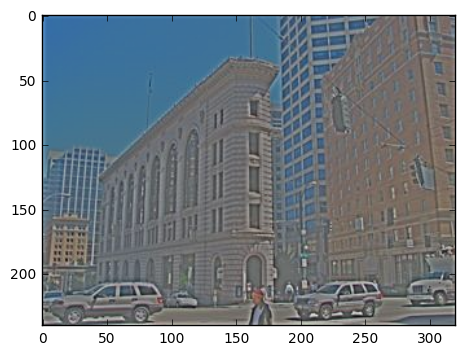

In [214]:
plt.imshow(((pf - pf.min())/(pf.max() - pf.min())))    ## Scaled between 0 to 1

### Divisive Normalization

In [89]:
sum_sqr_XX = F.conv2d(centered_image.pow(2),gfilter,padding=8)

In [90]:
denom = sum_sqr_XX[:,:,mid:-mid,mid:-mid].sqrt()

In [91]:
denom.shape

torch.Size([1, 1, 240, 320])

In [92]:
per_img_mean = denom.mean()

In [93]:
per_img_mean

tensor(29.5007)

In [94]:
divisor = np.maximum(per_img_mean.numpy(),denom.numpy())

divisor = np.maximum(divisor, 1e-4)

In [95]:
new_image = centered_image / torch.Tensor(divisor)

In [130]:
new_image.shape

torch.Size([1, 3, 240, 320])

### Putting it all together in a function

In [275]:
def LocalContrastNorm(image,radius=9):
    """
    image: torch.Tensor , .shape => (1,channels,height,width) 
    
    radius: Gaussian filter size (int), odd
    """
    if radius%2 == 0:
        radius += 1
    def get_gaussian_filter(kernel_shape):
        x = np.zeros(kernel_shape, dtype='float64')
 
        def gauss(x, y, sigma=2.0):
            Z = 2 * np.pi * sigma ** 2
            return  1. / Z * np.exp(-(x ** 2 + y ** 2) / (2. * sigma ** 2))
 
        mid = np.floor(kernel_shape[-1] / 2.)
        for kernel_idx in range(0, kernel_shape[1]):
            for i in range(0, kernel_shape[2]):
                for j in range(0, kernel_shape[3]):
                    x[0, kernel_idx, i, j] = gauss(i - mid, j - mid)
 
        return x / np.sum(x)
    
    n,c,h,w = image.shape[0],image.shape[1],image.shape[2],image.shape[3]

    gaussian_filter = torch.Tensor(get_gaussian_filter((1,c,radius,radius)))
    filtered_out = F.conv2d(image,gaussian_filter,padding=radius-1)
    mid = int(np.floor(gaussian_filter.shape[2] / 2.))
    ### Subtractive Normalization
    centered_image = image - filtered_out[:,:,mid:-mid,mid:-mid]
    
    ## Variance Calc
    sum_sqr_image = F.conv2d(centered_image.pow(2),gaussian_filter,padding=radius-1)
    s_deviation = sum_sqr_image[:,:,mid:-mid,mid:-mid].sqrt()
    per_img_mean = denom.mean()
    
    ## Divisive Normalization
    divisor = np.maximum(per_img_mean.numpy(),s_deviation.numpy())
    divisor = np.maximum(divisor, 1e-4)
    new_image = centered_image / torch.Tensor(divisor)
    return new_image

In [276]:
ret = LocalContrastNorm(image_tensor,radius=9)

In [277]:
ret = ret[0].numpy().transpose((1,2,0))

In [290]:
scaled_ret = (ret - ret.min())/(ret.max() - ret.min())   ## Scaled between 0 to 1 to see properly

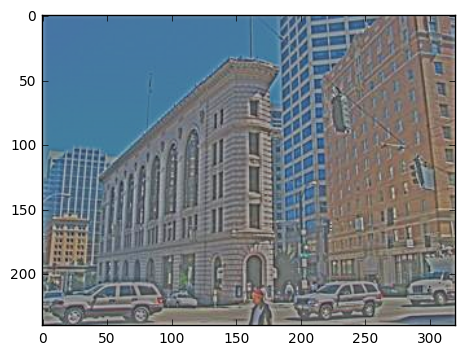

In [279]:
plt.imshow(scaled_ret)

In [280]:
import subprocess

In [281]:
images_list = subprocess.getoutput('ls images/').split('\n')

In [282]:
images = [plt.imread('images/'+i) for i in images_list]

[plt.imsave('{}.png'.format(i),images[i]) for i in range(8)]

for i in range(8):
    ret = LocalContrastNorm(torch.Tensor([images[i].transpose((2,0,1))]),radius=9)
    ret = ret[0].numpy().transpose((1,2,0))
    scaled_ret = (ret - ret.min())/(ret.max() - ret.min())   ## Scaled between 0 to 1
    plt.imsave('{}_lcn.png'.format(i),scaled_ret)